# Simple Market Sentiment Template

An environmental process model simulating cycles of fear and greed. This is intended to be used as a component that can be integrated into other cadCAD systems to inform agent actions. It's a work in progress. PRs welcome.

## To Do Box

Create a cyclical loop that winds up and down so that sentiment cycles between 1 and 100

New plan:

- There's a random number generator between x and y
- At every T timesteps X and Y move up or down, moving the range of the randomness
- This means that the numbers will be random, but there's a cyclical range they will occur within

## Check cadCAD

This cell doesn't do anything, but it does ensure that you know what version of cadCAD you're running. That way if/when you encounter technical difficulties you can tell the community which version of cadCAD you're running. Might save you hours of pain if all you need to do is upgrade to the latest version. 

In [1]:
%pip show cadCAD

Name: cadCAD
Version: 0.4.23
Summary: cadCAD: a differential games based simulation software package for research, validation, and         Computer Aided Design of economic systems
Home-page: https://github.com/cadCAD-org/cadCAD
Author: Joshua E. Jodesty
Author-email: joshua@block.science
License: LICENSE.txt
Location: /usr/local/lib/python3.8/dist-packages
Requires: pathos, pandas, funcy, fn
Required-by: cadCAD-diagram
Note: you may need to restart the kernel to use updated packages.


## Import Stuff

These are the libraries you'll need (cadCAD stuff) and that could be useful (python stuff) for your cadCAD model.

We're using [cadCAD Diagram](https://github.com/cadCAD-org/cadCAD_diagram), which is separate from cadCAD. If you're using the VS Code container from this repo it's already installed, but otherwise you might need to instal it.

In [2]:
# Python
import numpy as np
import random as random

# cadCAD
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor
from cadCAD_diagram import diagram_from_config

# Notebook setup
experiment = Experiment()
del configs[:]

## Initial Params

These are the parameters that control the behavior of a system. For example, if you were modeling a Web3 protocol these would be the parameters within a system that token holders could vote to modify. All of the parameters of a protocol that can be modified should be accessible here. That way it's easy to modify and run similations to explore how parameter changes might affect the network.

In [3]:
# The initial state of the system
genesis_states = {
    # high numbers are optimistic, low numbers are pessimistic
    'sentiment': 100,
    # should oscillate between -10 and 10
    'cycle_position': 0,
    # 0 for bear, 1 for bull
    'cycle_type': 1
}

# The parameters to run the model
params = {
    # Params within the system
    'M': {
        # The degree of randomness vs determinism in the model
        # It's actually the standard deviation in np.random.normal()
        # That random number is used in the stochastic sentiment policy
        'stochasticity': [10],
        # The amount that the mean of np.random.normal() moves up or
        # down per timestep in bull and bear cycles
        'cycle_rachet': [1]
    },
    # Timesteps per run
    'T': range(100),
    # Number of parallel runs
    'N': 10
}

## Policy Functions

Policy functions are like flows in stock and flow diagrams. They modify the inputs to state update functions.

In [4]:
import numpy as numpy
test = round(np.random.normal(-5, 5))
print(test)

-4


In [5]:
def p_cycle_type(params, step, sH, s):
    # Variables
    position = s['cycle_position']
    new_type = s['cycle_type']
    # Logic
    if position == 10:
        new_type = 0
    elif position == -10:
        new_type = 1
    # Output
    return ({'new_type': new_type})

def p_cycle_position(params, step, sH, s):
    # Variables
    position = s['cycle_position']
    type = s['cycle_type']
    rachet = params['cycle_rachet']
    new_position = position
    # Logic
    if type == 1:
        new_position = position + rachet
    else:
        new_position = position - rachet
    # Output
    return ({'new_position': new_position})

#Deteremine the overall market sentiment at this time step
def p_sentiment(params, step, sH, s):
    # Variables
    sentiment = s['sentiment']
    position = s['cycle_position']
    stochasticity = params['stochasticity']
    # Logic
    new_sentiment = sentiment + round(np.random.normal(position, stochasticity))
    # Output
    return ({'new_sentiment': new_sentiment})

## State Update Functions

These functions take in inputs (state variables and policies) and modify the state.

In [6]:
def s_cycle_type(params, step, sH, s, _input):
    y = 'cycle_type'
    x = s[y]
    x = _input['new_type']
    return (y, x)

def s_cycle_position(params, step, sH, s, _input):
    y = 'cycle_position'
    x = s[y]
    x = _input['new_position']
    return (y, x)

def s_sentiment(params, step, sH, s, _input):
    y = 'sentiment'
    x = s[y]
    x = _input['new_sentiment']
    return (y, x)


## State Update Block

If you're approaching cadCAD from Web3 you can think of the state of the model as something that evolves in blocks. Each block has a set of actions that updates the state. Those transactions then get batched into blocks to be processed together. In cadCAD blocks are called "`partial_state_update_blocks`." As you can see below, this is an array that is very similar to a "block" in a blockchain in that it represents a set of actions to update the state. That state is then updated across many timesteps. This is similar to how the state of a blockchain is updated over many timesteps as new blocks are added.



In [7]:
partial_state_update_blocks = [
    {
        'policies': {
            'new_type': p_cycle_type  
        },
        'variables': {
            'cycle_type': s_cycle_type
        }
    },
    {
        'policies': {
            'new_position': p_cycle_position
        },
        'variables': {
            'cycle_position': s_cycle_position
        }
    },
    {
        'policies': {
            'new_sentiment': p_sentiment
        },
        'variables': {
            'sentiment': s_sentiment
        }
    }
]

## Running the cadCAD Engine

In [8]:
experiment.append_configs(
    initial_state = genesis_states,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = config_sim(params)
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs) 
raw_system_events, tensor_field, sessions = simulation.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 2, 10, 3)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 0.25s


## Data Visualization

This is often half the battle. Not only do need to design and build a cadCAD model, but you need to understand how it's working and be able to effectively communicate that to other people. A picture says a thousand words, thus enter data viz. Getting good at using python data viz libraries is probably the highest leverage thing you can do after you learn the cadCAD basics.

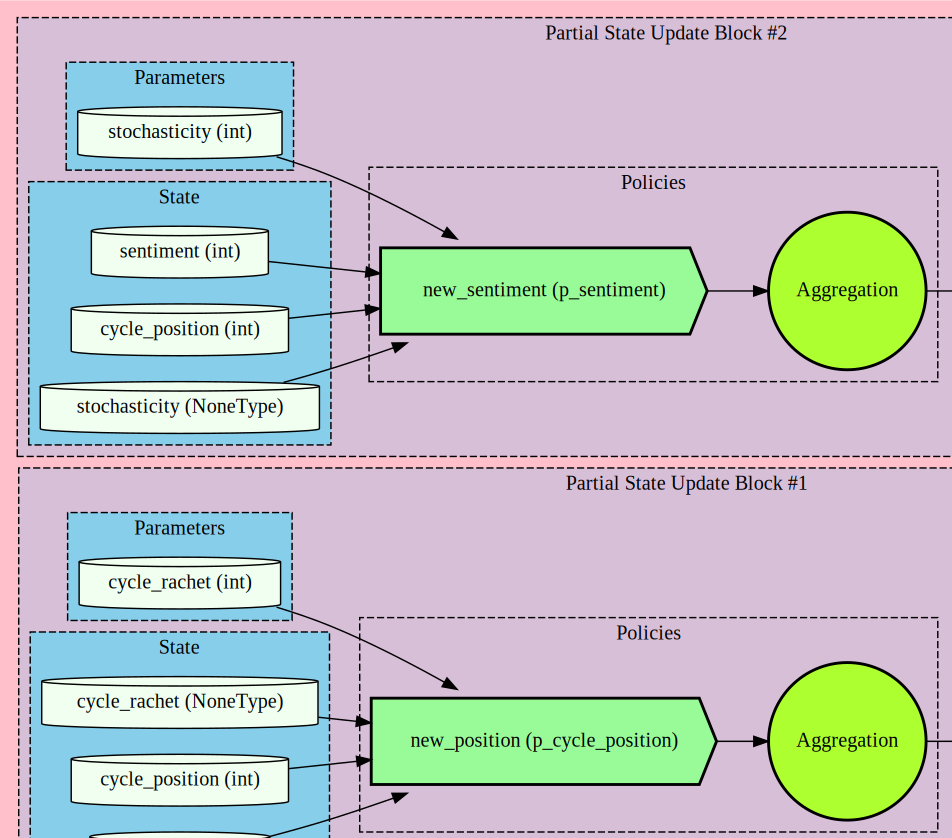

In [9]:
diagram_from_config(configs[0])

In [10]:
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

sentiment  cycle_position  cycle_type  simulation
subset run timestep substep                                                   
0      1   0        0              100               0           1           0
           1        1              100               0           1           0
                    2              100               1           1           0
                    3              105               1           1           0
           2        1              105               1           1           0
...                                ...             ...         ...         ...
       10  99       2              146               1           0           0
                    3              154               1           0           0
           100      1              154               1           0           0
                    2              154               0           0           0
                    3              157               0           0           0

[3010 rows x 4 columns]

<AxesSubplot:xlabel='timestep'>

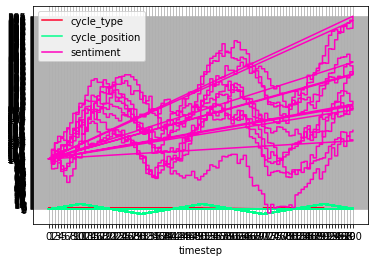

In [11]:
simulation_result.plot('timestep', ['cycle_type', 'cycle_position', 'sentiment'], grid=True, 
        colormap = 'gist_rainbow',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['sentiment'] + simulation_result['cycle_position'] + simulation_result['cycle_type']).max())))